# 1. Import Libraries and Load Environment

In [1]:
import os
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from pipeline_utils import CustomRowTransformer
from dotenv import load_dotenv
from benchmarks import ml_benchmarks, custom_ml_benchmarks, optimize_xgboost
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import os
from tabulate import tabulate  
load_dotenv()
ML_PREPROC_FILENAME = os.getenv("ML_PREPROC_FILENAME")
CSV_FOLDER = os.getenv("CSV_FOLDER")
CSV_TRAIN_FILENAME = os.getenv("CSV_TRAIN_FILENAME")

Preprocessing pipeline will be saved to: c:\Users\Fernando\VSC\python\dev\p7-1\multi-class_prediction_obesity_risk\data\modeling\pkl\preprocessing_pipeline.pkl
✅ Preprocessing pipeline saved to: c:\Users\Fernando\VSC\python\dev\p7-1\multi-class_prediction_obesity_risk\data\modeling\pkl\preprocessing_pipeline.pkl


c:\Users\Fernando\VSC\python\dev\p7-1\multi-class_prediction_obesity_risk\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Load Data and Preprocess PKL

In [2]:
# Paths
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
csv_path = os.path.join(parent_dir, ".kaggle", "train.csv")
print(f'CSV path: {csv_path}')
pre_pkl_path = os.path.join(parent_dir, "modeling", "pkl", ML_PREPROC_FILENAME)
print(f'Preprocessing pipeline path: {pre_pkl_path}')

# Load raw data and preprocessing pipeline
df = pd.read_csv(csv_path)
preprocessing_pipeline = joblib.load(pre_pkl_path)


CSV path: c:\Users\Fernando\VSC\python\dev\p7-1\multi-class_prediction_obesity_risk\data\.kaggle\train.csv
Preprocessing pipeline path: c:\Users\Fernando\VSC\python\dev\p7-1\multi-class_prediction_obesity_risk\data\modeling\pkl\preprocessing_pipeline.pkl


# 3. APPLY PIPELINE AND SPLIT FEATURES AND TARGET

In [3]:
# Apply preprocessing
df_prepared = preprocessing_pipeline.transform(df)   

# Separate features and target
X = df_prepared.drop(columns=["NObeyesdad", "SMOKE","MTRANS","id"])
y = df_prepared["NObeyesdad"]



# 4. OBTAIN MODELS BENCHMARK

In [4]:
ml_benchmarks(X, y)

c:\Users\Fernando\VSC\python\dev\p7-1\multi-class_prediction_obesity_risk\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:13:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1120
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 15
[LightGBM] [Info] Start training from score -2.107657
[LightGBM] [Info] Start training from score -1.907572
[LightGBM] [Info] Start training from score -1.964755
[LightGBM] [Info] Start training from score -1.855022
[LightGBM] [Info] Start training from score -1.635117
[LightGBM] [Info] Start training from score -2.146046
[LightGBM] [Info] Start training from score -2.107657


c:\Users\Fernando\VSC\python\dev\p7-1\multi-class_prediction_obesity_risk\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Fernando\VSC\python\dev\p7-1\multi-class_prediction_obesity_risk\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


+---------------------+--------------------+--------------------+--------------------+--------------------+----------------+-------------+
|        Model        |      Accuracy      |     Precision      |       Recall       |      F1-Score      | Train Time (s) | Overfitting |
+---------------------+--------------------+--------------------+--------------------+--------------------+----------------+-------------+
|       XGBoost       | 0.9072736030828517 | 0.9070431550288031 | 0.9072736030828517 | 0.9070520800655331 |     5.6426     |   0.0769    |
|      CatBoost       | 0.9060693641618497 | 0.9055571752237769 | 0.9060693641618497 | 0.9057671655185464 |    68.0279     |   0.0483    |
|      LightGBM       | 0.9051059730250481 | 0.904767060264294  | 0.9051059730250481 | 0.904858615859683  |     8.7731     |   0.0711    |
|    Random Forest    | 0.898121387283237  | 0.8973051070129009 | 0.898121387283237  | 0.8975369106223903 |     5.221      |   0.1018    |
|      SVM (RBF)      | 0.8

,Model,Accuracy,Precision,Recall,F1-Score,Train Time (s),Overfitting
7,XGBoost,0.907274,0.907043,0.907274,0.907052,5.6426,0.0769
9,CatBoost,0.906069,0.905557,0.906069,0.905767,68.0279,0.0483
8,LightGBM,0.905106,0.904767,0.905106,0.904859,8.7731,0.0711
2,Random Forest,0.898121,0.897305,0.898121,0.897537,5.2210,0.1018
4,SVM (RBF),0.883189,0.882230,0.883189,0.882603,15.5694,0.0137
3,SVM (Linear),0.869701,0.868421,0.869701,0.868777,10.8462,-0.0029
0,Logistic Regression,0.863921,0.862367,0.863921,0.862864,1.0173,-0.0013
1,Decision Tree,0.839595,0.839947,0.839595,0.839534,0.3115,0.1603
6,KNN,0.793593,0.790631,0.793593,0.790766,0.3082,0.0574
5,Naive Bayes,0.775530,0.770976,0.775530,0.769140,0.0555,-0.0024


# 5. TRY CUSTOM MANUAL PIPELINES
As seen in benchmarking, XGBoost and Logistic Regression are the best performing models.
Now we will try to create a custom pipeline for each of them and see if we can get better results.

In [5]:
custom_pipelines = {
    'XGBoost (Ajustado)': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier(
            n_estimators=150,
            max_depth=4,
            learning_rate=0.07,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_alpha=0.5,
            reg_lambda=0.7,
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=42
        ))
    ]),

    'Logistic Regression (Ajustado)': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            C= 20.0,  # <--- Aumentado desde 1.0 para reducir la regularización
            penalty='l2',
            class_weight='balanced',
            max_iter=1000,
            solver='lbfgs',
            random_state=42
        ))
    ])
}

In [6]:
results_df = custom_ml_benchmarks(X, y, models_dict=custom_pipelines)

c:\Users\Fernando\VSC\python\dev\p7-1\multi-class_prediction_obesity_risk\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:14:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


+--------------------------------+--------------------+--------------------+--------------------+--------------------+----------------+-------------+
|             Model              |      Accuracy      |     Precision      |       Recall       |      F1-Score      | Train Time (s) | Overfitting |
+--------------------------------+--------------------+--------------------+--------------------+--------------------+----------------+-------------+
|       XGBoost (Ajustado)       | 0.9053468208092486 | 0.9048472242502588 | 0.9053468208092486 | 0.9049623394462658 |    11.3042     |   0.0097    |
| Logistic Regression (Ajustado) | 0.8639210019267822 | 0.8639142688637425 | 0.8639210019267822 | 0.8633476011203041 |     1.264      |   0.0002    |
+--------------------------------+--------------------+--------------------+--------------------+--------------------+----------------+-------------+


XGBoost seems to be the best performing model, so we will try to create a custom pipeline for it.

# 6. XGBOOST CUSTOM PIPELINE

In [7]:
optuna_pipeline, optuna_study, results, X_train, X_test, y_train, y_test = optimize_xgboost(X, y, n_trials=30)

[I 2025-05-23 11:14:55,197] A new study created in memory with name: no-name-8e7aad96-19fe-48c6-aa77-bf5c5a7c4b51
c:\Users\Fernando\VSC\python\dev\p7-1\multi-class_prediction_obesity_risk\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:14:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-05-23 11:15:03,824] Trial 0 finished with value: 0.8986030828516378 and parameters: {'n_estimators': 252, 'max_depth': 8, 'learning_rate': 0.2012686268902643, 'subsample': 0.5549128978379396, 'colsample_bytree': 0.9723005110107931, 'gamma': 4.287770199603372, 'reg_alpha': 0.6169407429312445, 'reg_lambda': 0.16425982926661664}. Best is trial 0 with value: 0.8986030828516378.
c:\Users\Fernando\VSC\python\dev\p7-1\multi-class_prediction_obesity_risk\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:15:03] WARNING: C:\actions-runner\_work\xgboost\x

+------------------+-------------------+--------------------+-------------------+-------------------+-------------+
|      Model       |     Accuracy      |     Precision      |      Recall       |     F1-Score      | Overfitting |
+------------------+-------------------+--------------------+-------------------+-------------------+-------------+
| XGBoost (Optuna) | 0.911849710982659 | 0.9115518020067495 | 0.911849710982659 | 0.911526046549036 |   0.0214    |
+------------------+-------------------+--------------------+-------------------+-------------------+-------------+


<Figure size 800x600 with 0 Axes>

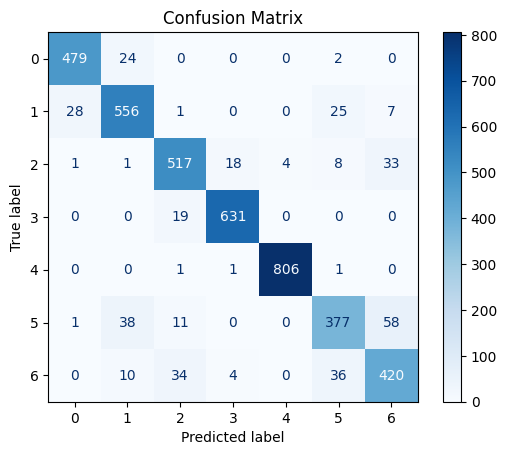

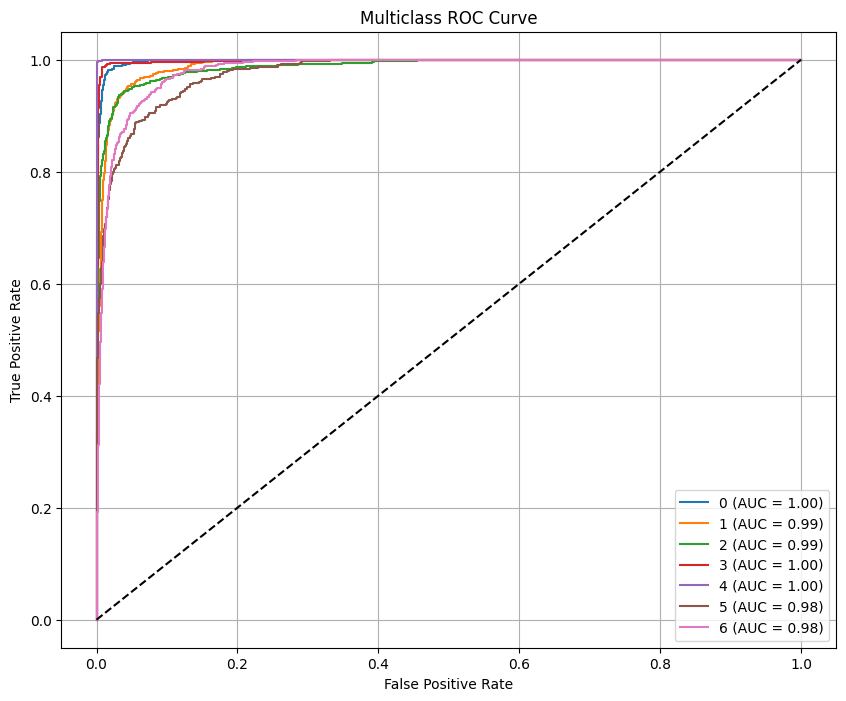

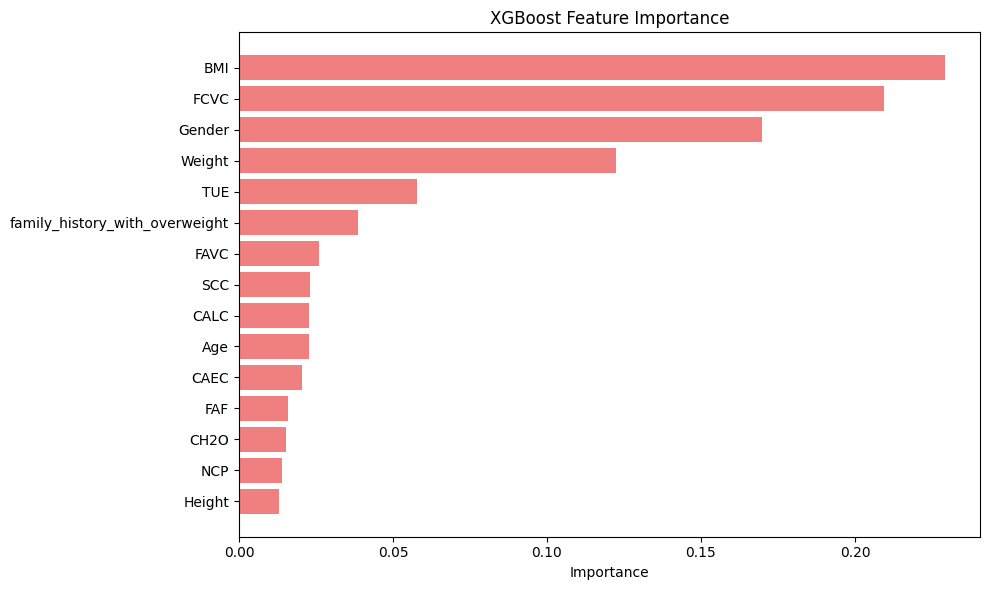

In [8]:
# ==== Final Model Evaluation: Classification Report ====
print(tabulate(results, headers='keys', tablefmt='pretty'))
# ==== Final Model Evaluation: Visualizations ====

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = optuna_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=optuna_pipeline.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Multiclass ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]
y_score = optuna_pipeline.predict_proba(X_test)

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Feature Importance for XGBoost
feature_names = X_train.columns
xgb_model = optuna_pipeline.named_steps['classifier']
importances = xgb_model.feature_importances_

feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='lightcoral')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


# 7. TRAIN MODEL

In [9]:
# y_pred = optuna_pipeline.predict(X)
# y_proba = optuna_pipeline.predict_proba(X)


# 8. EXPORT MODEL

In [10]:

# current_dir = os.getcwd()
# model_pkl_filename = "xgboost_optuna_pipeline.pkl"
# model_pkl_path = os.path.join(current_dir, "pkl",model_pkl_filename)

# joblib.dump(optuna_pipeline, model_pkl_path)

# print(f"✔️ Modelo guardado en: {model_pkl_path}")